#### Welcome, in this notebook I will present my end-of-course project for the Supervised Machine Learning: Classification course for the IBM Professional Certification in Machine Learning (https://www.coursera.org/professional-certificates/ibm-machine-learning)

#### In this project, we will see the main operations that need to be performed in a regression problem:
- Exploratory Data Analysis;
- Feature Engineering;
- Modeling;
- Validation.

#### The dataset I used can be found at https://www.kaggle.com/datasets/arnabchaki/data-science-salaries-2023

#### This dataset contains info about salaries of different Data Science fields in the Data Science Domain.

Data Science Job Salaries Dataset contains 11 columns, each are:

* work_year: The year the salary was paid;
* experience_level: The experience level in the job during the year;
* employment_type: The type of employment for the role;
* job_title: The role worked in during the year;
* salary: The total gross salary amount paid;
* salary_currency: The currency of the salary paid as an ISO 4217 currency code;
* salaryinusd: The salary in USD;
* employee_residence: Employee's primary country of residence in during the  work year as an ISO 3166 country code;
* remote_ratio: The overall amount of work done remotely;
* company_location: The country of the employer's main office or contracting branch;
* company_size: The median number of people that worked for the company during the year.


#### The first step is to download the dataset. To obtain a dataset from Kaggle, you can either download it through the web interface or use the APIs. To use the APIs, you need to have the 'kaggle' command installed and an access token, which will be a .json file that should be placed in the directory containing the 'kaggle' command (in my case, /root/.kaggle/)

#### As always, I recommend to use Google Colab instead of your machine to run ML application if you don't have GPU or a strong computation support.

In [ ]:
# On Google Colab, it is already installed
!pip install kaggle

In [4]:
!mv /content/kaggle.json /root/.kaggle/

Note: if this command give you an error such as "No such file or directory", try to exec the next command the first time(to download the dataset), then exec this again and than the command to download the dataset again

In [ ]:
!kaggle datasets download -d arnabchaki/data-science-salaries-2023

In [ ]:
!unzip /content/data-science-salaries-2023.zip

#### Import the required libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## EDA

Read your chosen dataset into pandas dataframe:


In [8]:
data = pd.read_csv("/content/ds_salaries.csv")
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


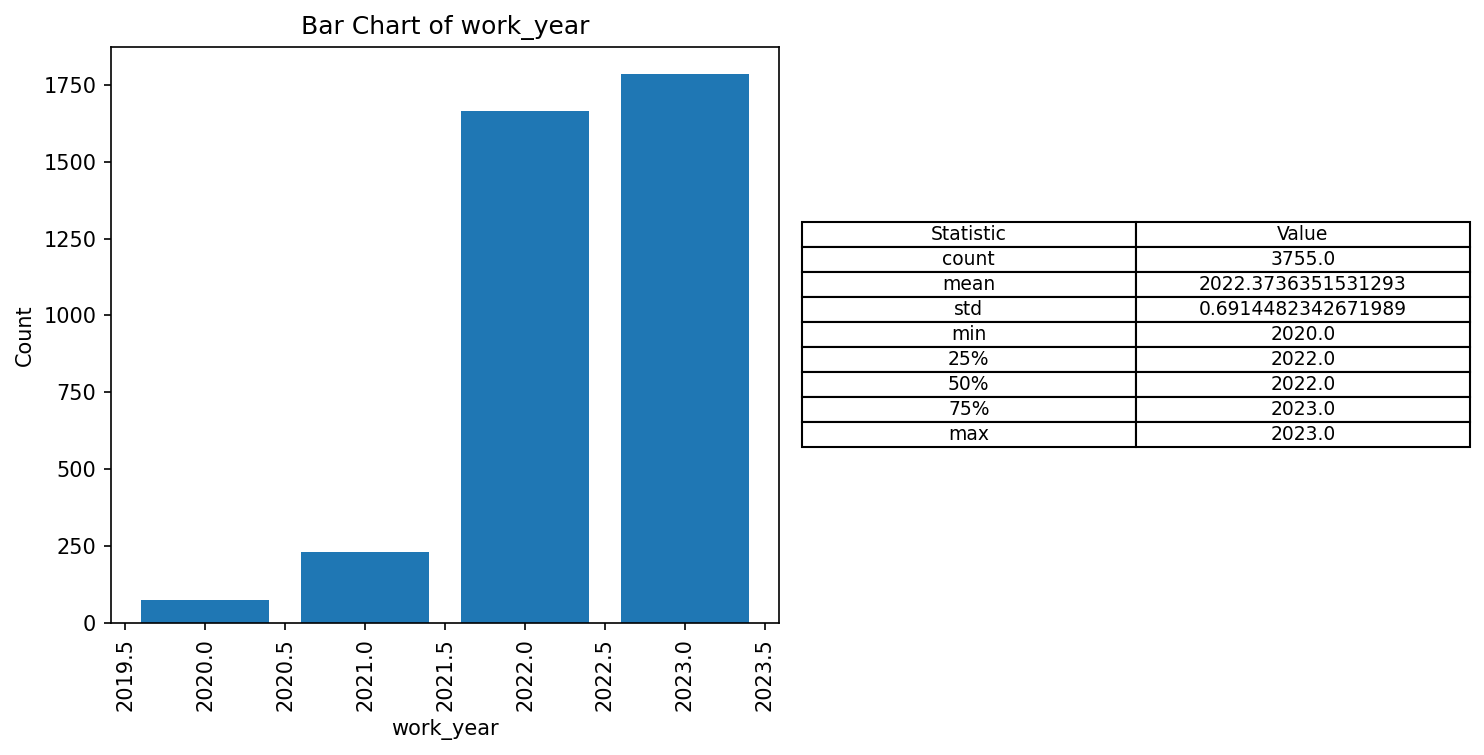

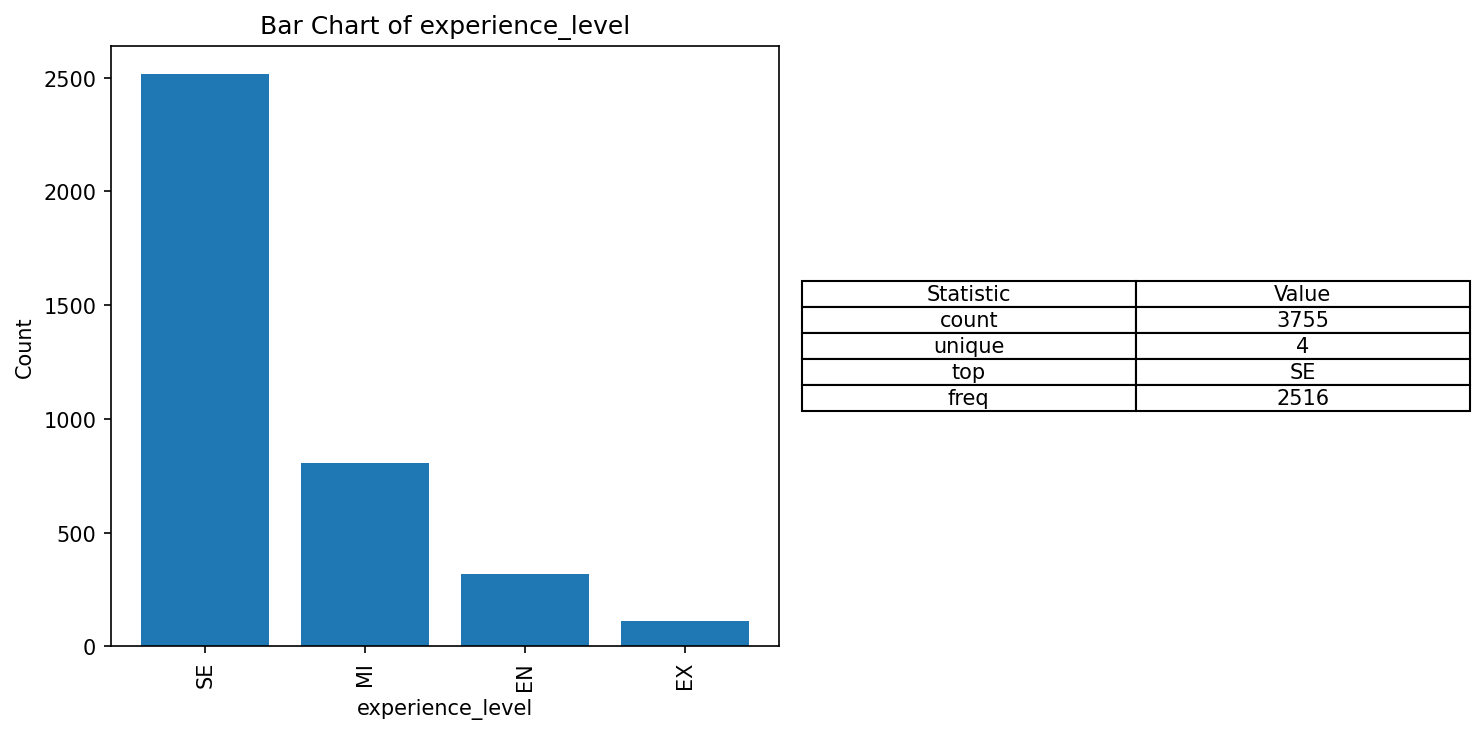

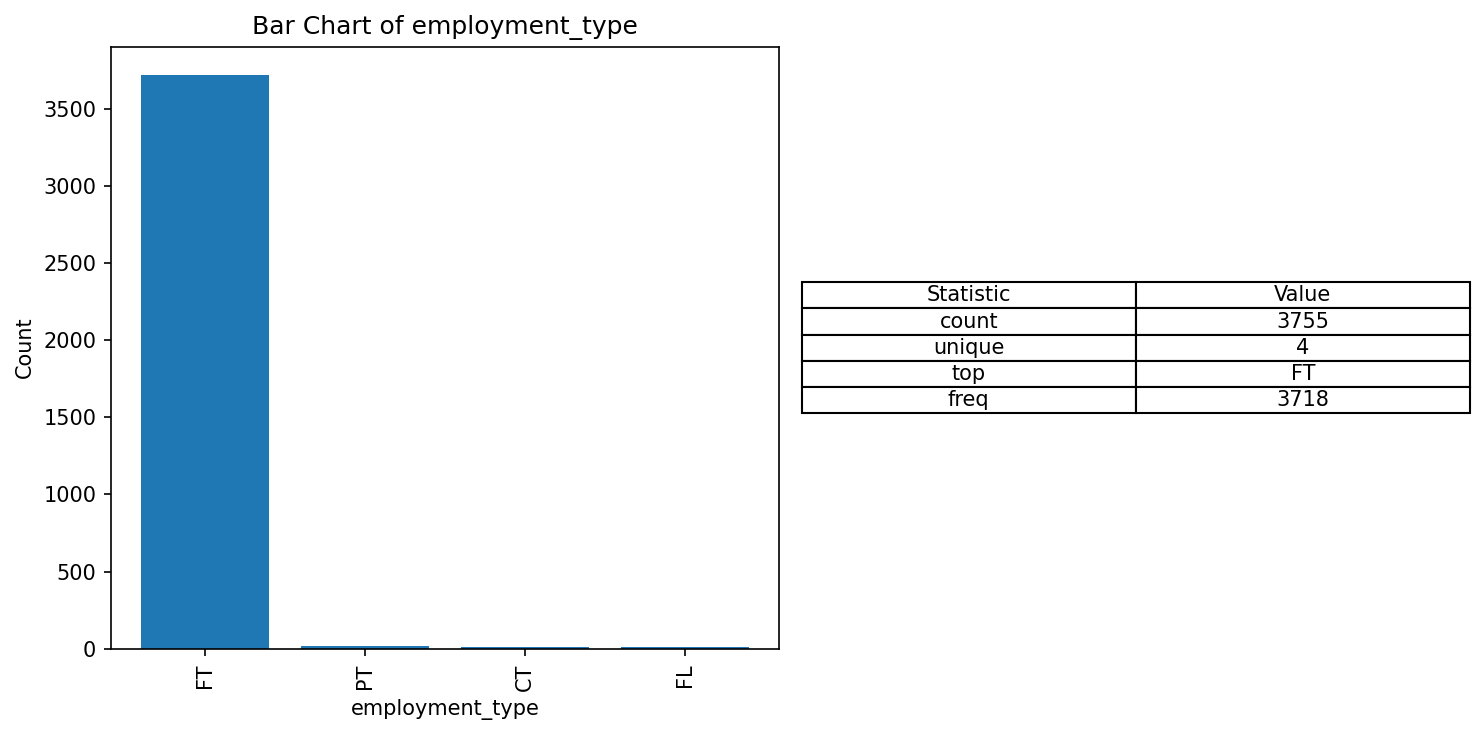

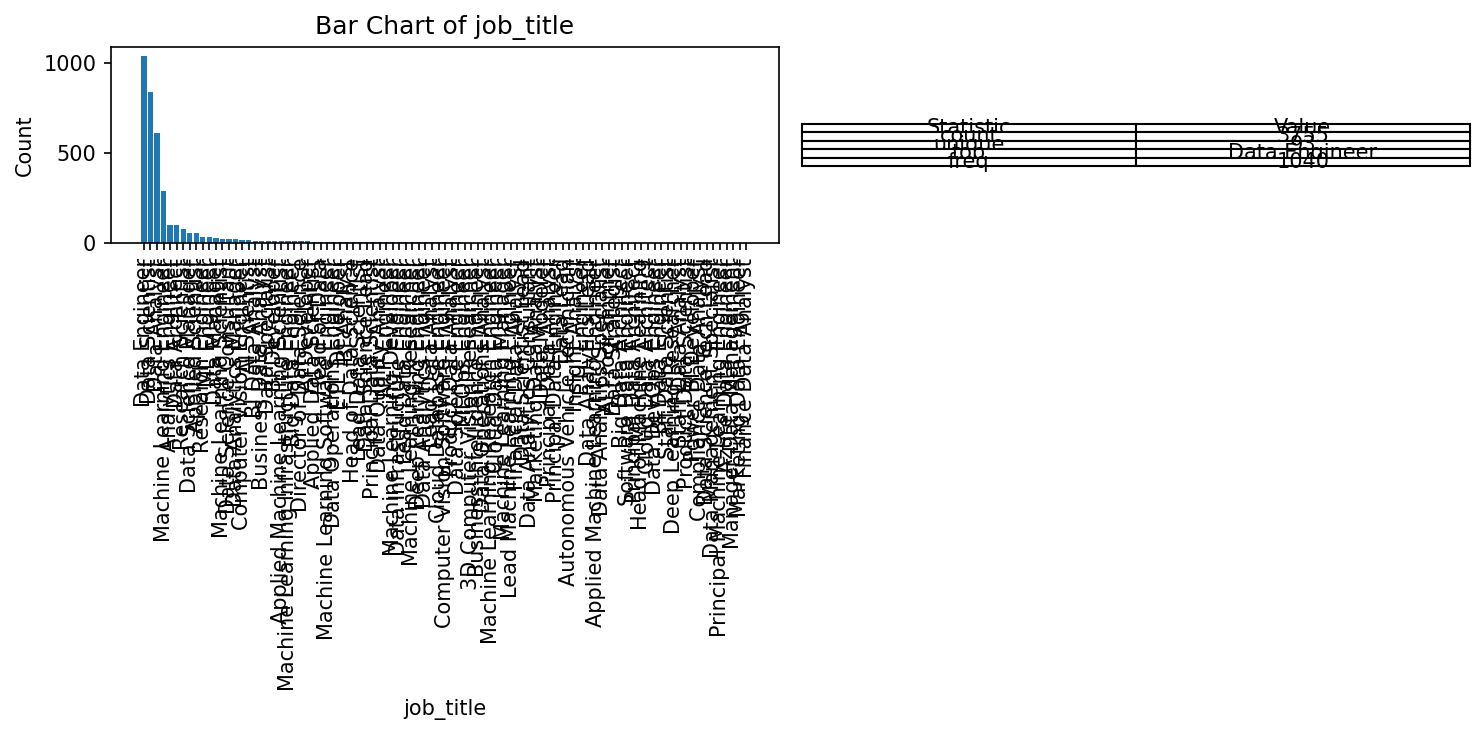

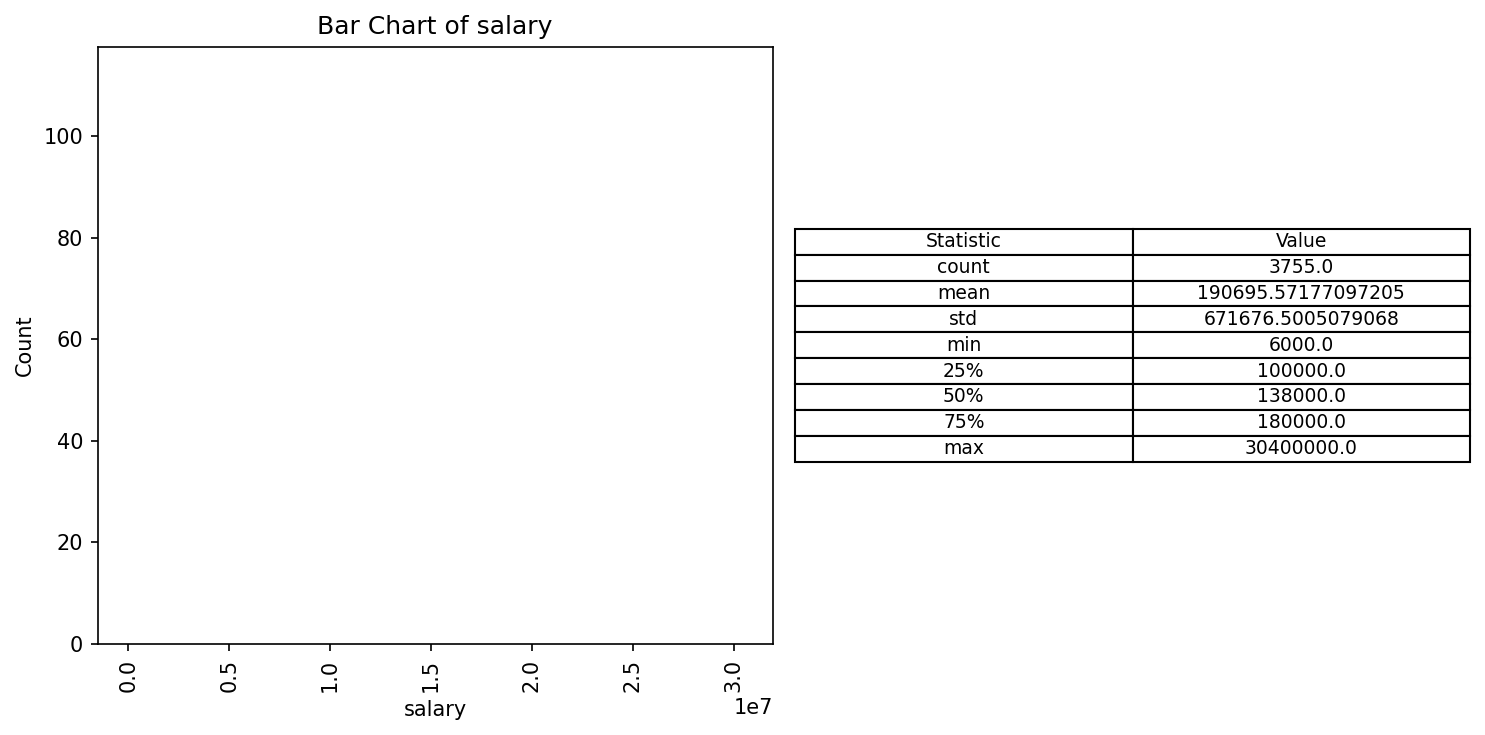

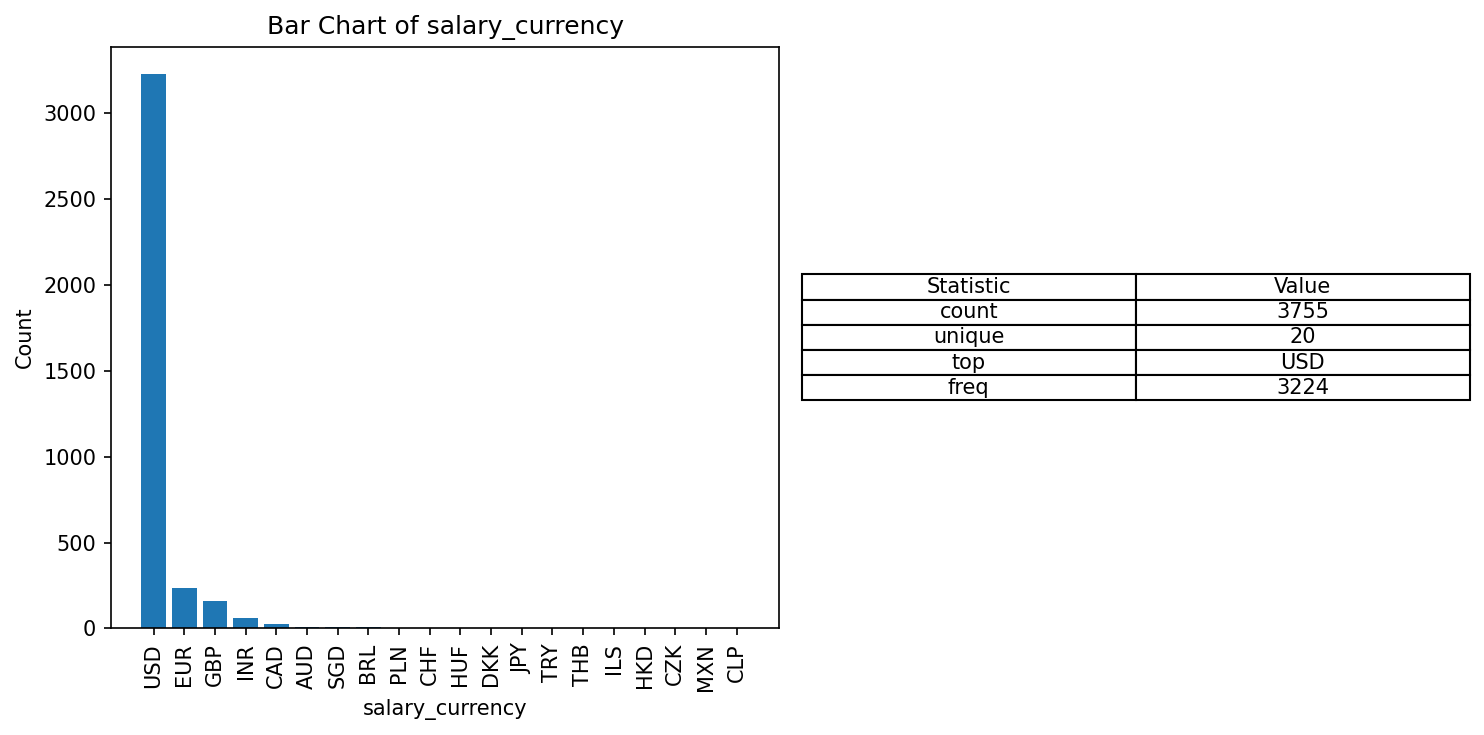

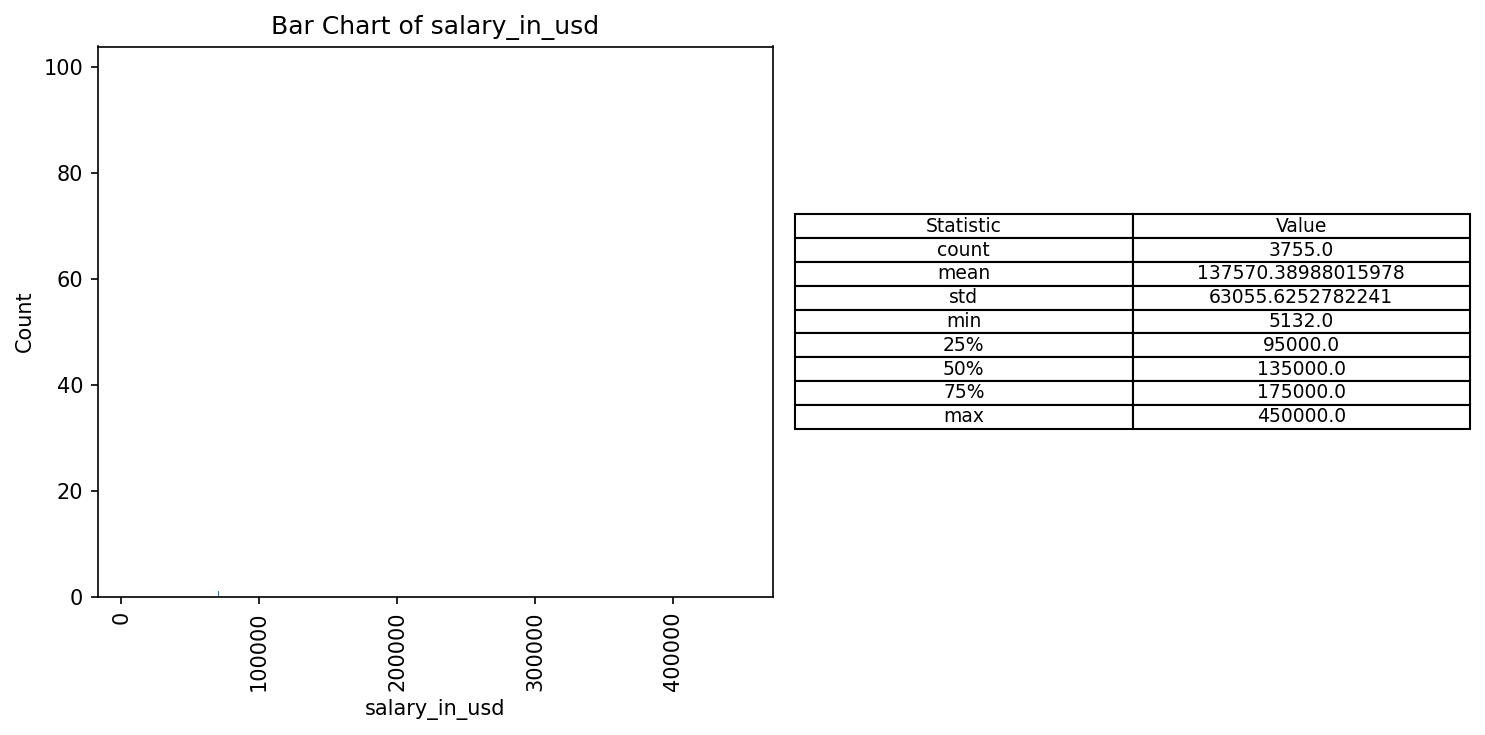

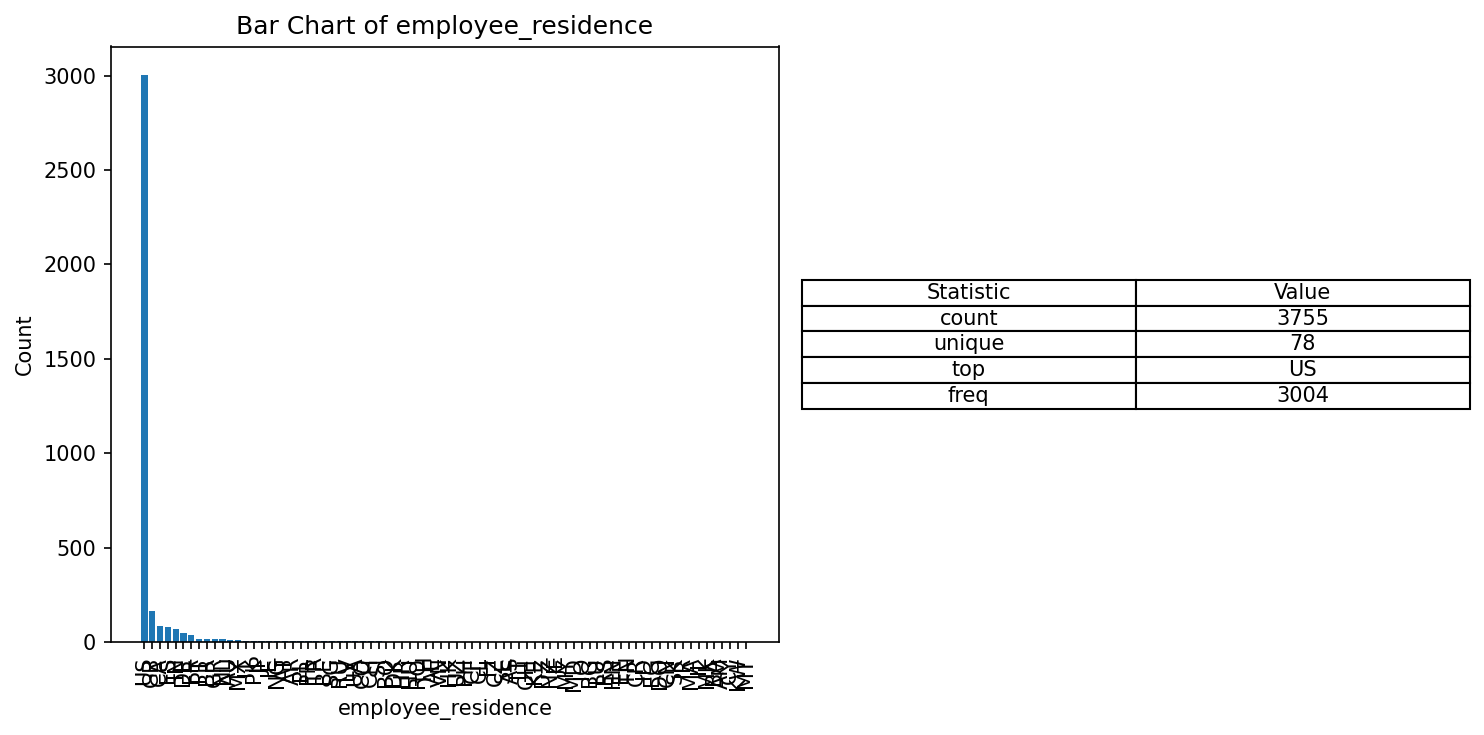

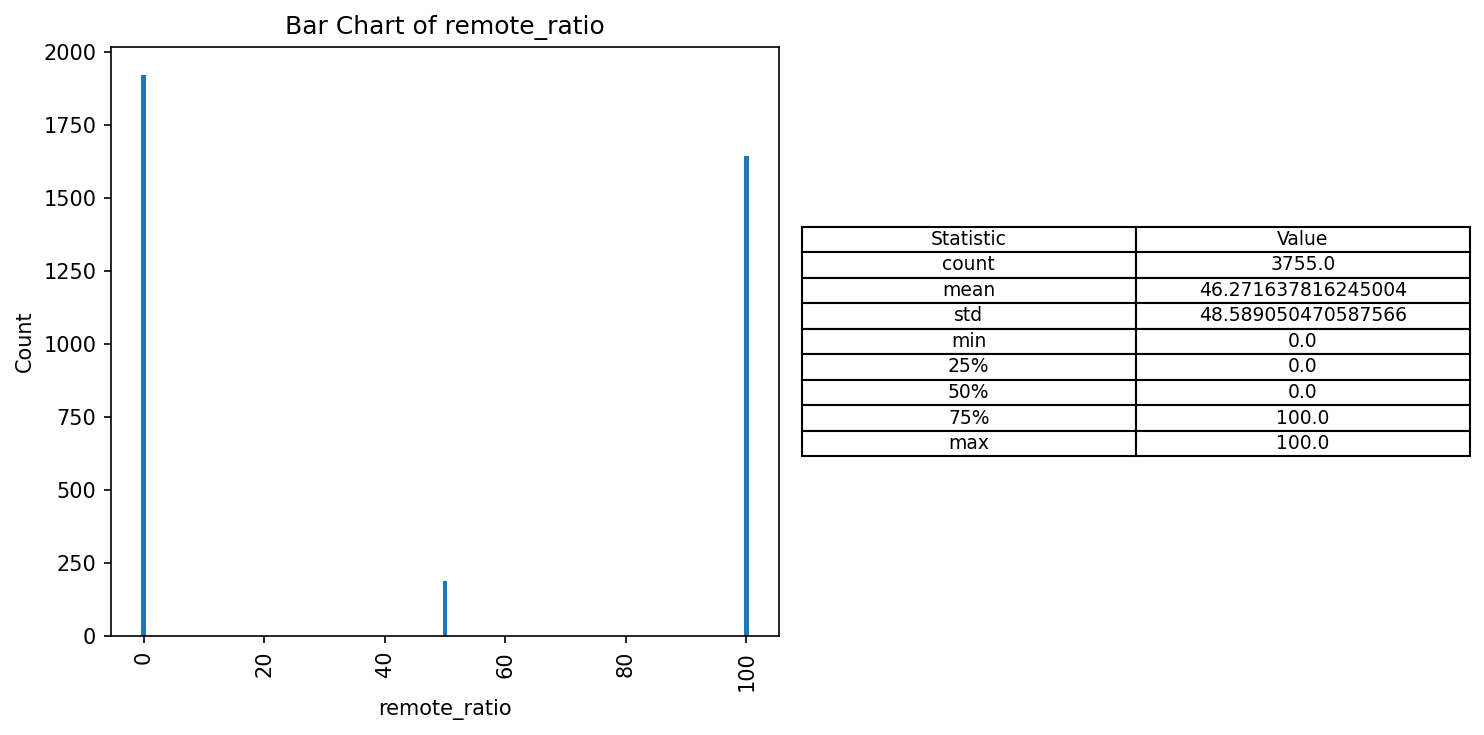

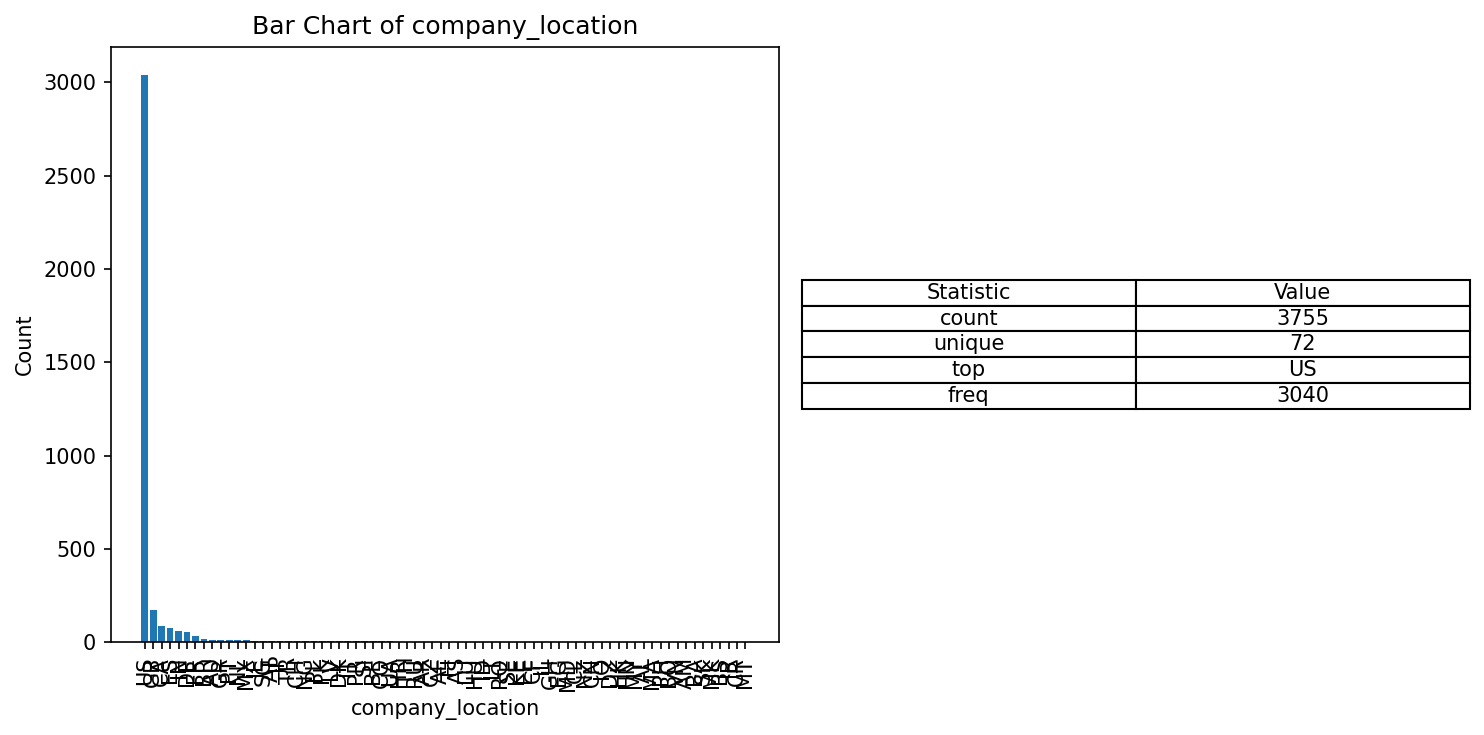

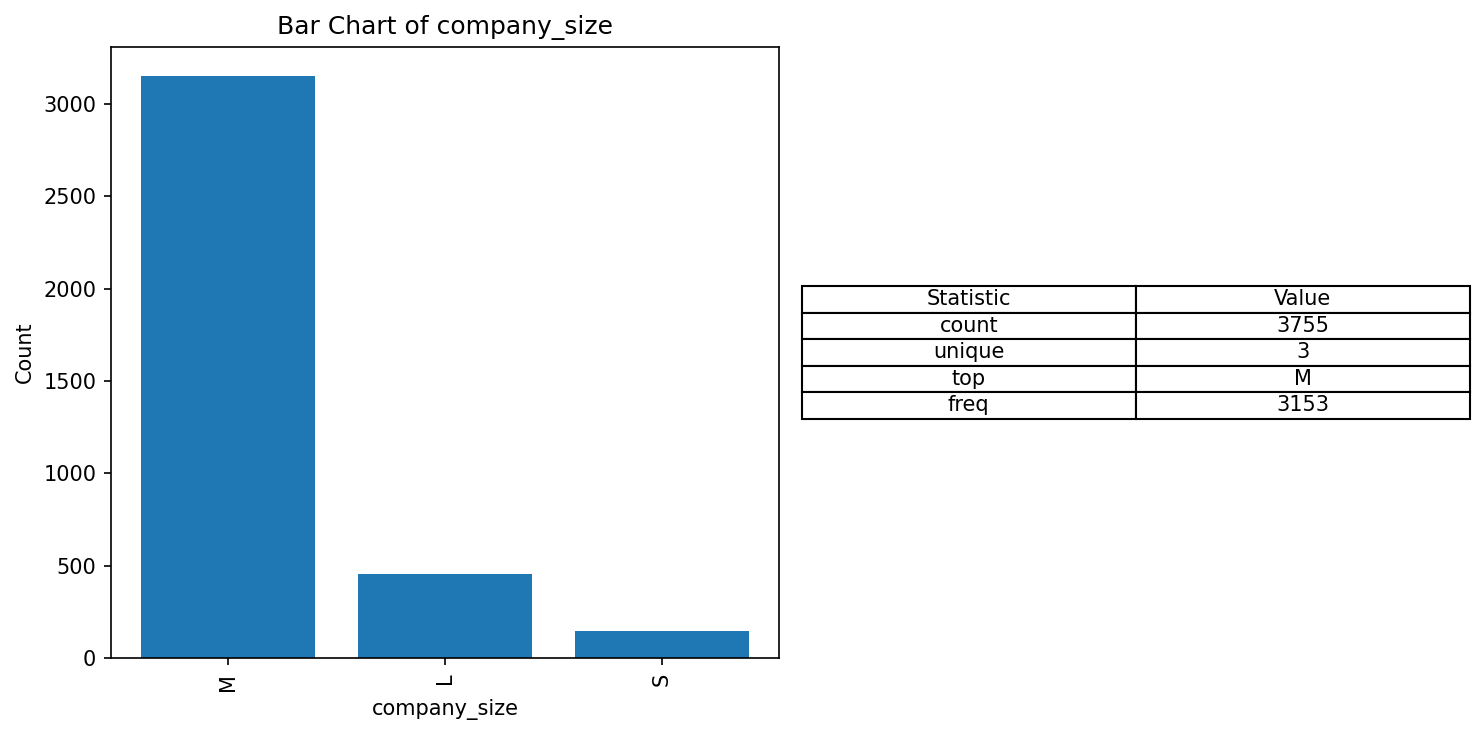

In [11]:
import matplotlib.pyplot as plt

# Define the number of columns for your subplots
num_columns = len(data.columns)

# Increase the DPI (dots per inch) for higher resolution
dpi = 150  # Adjust this value for your desired resolution

# Loop through each column and create a separate figure for each chart with statistics
for i, column in enumerate(list(data.columns)):
    value_counts = data[column].value_counts()

    # Create a subplot grid with 1 row and 2 columns (for the chart and statistics)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=dpi)  # Adjust the figsize and dpi as needed

    # Plot the bar chart
    ax1 = axes[0]
    ax1.bar(value_counts.index, value_counts)
    ax1.set_xlabel(column)
    ax1.set_ylabel('Count')
    ax1.set_title(f'Bar Chart of {column}')
    ax1.tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability

    # Add statistics table next to the chart
    ax2 = axes[1]
    ax2.axis('off')  # Turn off axis for the statistics table
    stats_table = data[column].describe().reset_index()
    cell_text = []
    for row in stats_table.values:
        cell_text.append([str(val) for val in row])
    ax2.table(cellText=cell_text, colLabels=['Statistic', 'Value'], cellLoc='center', loc='center')

    plt.tight_layout()  # Ensure proper spacing
    plt.savefig(f'bar_chart_with_stats_{column}.png', dpi=dpi, bbox_inches='tight')  # Save each figure as a separate PNG
    plt.show()

We need to make some considerations about data (The bar chart is not very useful for many of these columns)

The column __work_year__ and __experience_level__ can take only 4 possible values; during the feature engineering phase, we will perform one-hot encoding on it.

However, the column __company_size__ can take only 3 possible values so, during the feature engineering phase, we will perform one-hot encoding on it.

In [10]:
print(data.work_year.value_counts(normalize=True)*100)
print(data.experience_level.value_counts(normalize=True)*100)
print(data.company_size.value_counts(normalize=True)*100)

2023    47.536618
2022    44.314248
2021     6.125166
2020     2.023968
Name: work_year, dtype: float64
SE    67.003995
MI    21.438083
EN     8.521971
EX     3.035952
Name: experience_level, dtype: float64
M    83.968043
L    12.090546
S     3.941411
Name: company_size, dtype: float64


The employment_type column also has only 4 possible value, but the column itself has a very low variance, because most of the values (approximatly the 99%) have the same value. So, for semplicity, we remove it

In [11]:
print(data.employment_type.value_counts(normalize=True)*100)

FT    99.014647
PT     0.452730
CT     0.266312
FL     0.266312
Name: employment_type, dtype: float64


There are 93 job title but only 9 out of 93 are greater than 1% of the total. So, you have only 2 choices:
* Keep all values;
* Take all infrequent values (we have chosen below 1% of the total) and aggregate them into a single value that we will call 'other'.

It's good practice, especially when the dataset is not too large, to try both approaches and see which performs better.



In [12]:
print(data.job_title.value_counts(normalize=True)*100)

print(data['job_title'].value_counts(normalize=True)[data['job_title'].value_counts(normalize=True)*100 > 1]*100)

Data Engineer                          27.696405
Data Scientist                         22.370173
Data Analyst                           16.298269
Machine Learning Engineer               7.696405
Analytics Engineer                      2.743009
                                         ...    
Principal Machine Learning Engineer     0.026631
Azure Data Engineer                     0.026631
Manager Data Management                 0.026631
Marketing Data Engineer                 0.026631
Finance Data Analyst                    0.026631
Name: job_title, Length: 93, dtype: float64
Data Engineer                27.696405
Data Scientist               22.370173
Data Analyst                 16.298269
Machine Learning Engineer     7.696405
Analytics Engineer            2.743009
Data Architect                2.689747
Research Scientist            2.183755
Data Science Manager          1.544607
Applied Scientist             1.544607
Name: job_title, dtype: float64


For __salary__ column, there are some very great values, it means there are outliers, but, not always outlier must be filtered as default, because there are some cases in which outliers represent valuable information.

In our case, this greater value was highly correlated to the Country in which the worker works.

Moreover, the __salary_in_usd__ column is a column with similar scope, but it is useful based on the type of problem we try to resolve.

For example, if our mean is to predict what is the job position of a worker, keep all salary columns is useless.

Managing outliers is never easy. So, for semplicity, we will filter some samples based on salary column.

In [13]:
data.sort_values(by='salary', ascending=False).salary.value_counts

<bound method IndexOpsMixin.value_counts of 3669    30400000
3646    11000000
3574    11000000
3475     8500000
2966     7500000
          ...   
3681        8000
2589        8000
2933        7500
573         7000
1548        6000
Name: salary, Length: 3755, dtype: int64>

In [14]:
print("People with salary greater than 500K")
print(len(data[data.sort_values(by='salary', ascending=False).salary > 500000].salary))

print("\n")

print("People with salary greater than 400K")
print(len(data[data.sort_values(by='salary', ascending=False).salary > 400000].salary))

print("\n")

print("People with salary greater than 300K")
print(len(data[data.sort_values(by='salary', ascending=False).salary > 300000].salary))

print("\n")

print("People with salary greater than 250K")
print(len(data[data.sort_values(by='salary', ascending=False).salary > 250000].salary))

People with salary greater than 500K
63


People with salary greater than 400K
75


People with salary greater than 300K
113


People with salary greater than 250K
224


For __employee_residence__ and __company_location__ columns,  we will perform the same operations as for column job_title.

In [15]:
print(data.employee_residence.value_counts(normalize=True)*100)

print(data['employee_residence'].value_counts(normalize=True)[data['employee_residence'].value_counts(normalize=True)*100 > 1]*100)

US    80.000000
GB     4.447403
CA     2.263648
ES     2.130493
IN     1.890812
        ...    
BA     0.026631
AM     0.026631
CY     0.026631
KW     0.026631
MT     0.026631
Name: employee_residence, Length: 78, dtype: float64
US    80.000000
GB     4.447403
CA     2.263648
ES     2.130493
IN     1.890812
DE     1.278296
FR     1.011984
Name: employee_residence, dtype: float64


In [16]:
print(data.company_location.value_counts(normalize=True)*100)

print(data['company_location'].value_counts(normalize=True)[data['company_location'].value_counts(normalize=True)*100 > 1]*100)

US    80.958722
GB     4.580559
CA     2.316911
ES     2.050599
IN     1.544607
        ...    
MK     0.026631
BS     0.026631
IR     0.026631
CR     0.026631
MT     0.026631
Name: company_location, Length: 72, dtype: float64
US    80.958722
GB     4.580559
CA     2.316911
ES     2.050599
IN     1.544607
DE     1.491345
Name: company_location, dtype: float64


## Feature Engineering

The operations we will perform are:

* One hot encoding on work_year and salary_currency;
* Ordinal encoding on experience_level because it will be our target column;
* Employment_type and salary_in_usd columns will be filtered;
* Job_title, employee_residence and company_location will have two types of processing:
  * The first one is a one hot encoding;
  * The second one is firstly an aggregating operation for all values with a presence percentage less than 1%, and then one-hot encoding;
* Salary will be normilized standard scaling while remote_ratio will be normalized with min-max scaling.


In [17]:
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# employment_type and salary_in_usd dropped
data.drop(['employment_type', 'salary_in_usd'], axis = 1, inplace = True)

# Outliers filtering
data = data[data['salary'] < 250000]

# Numerical features normalized
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()
data['salary'] = std_scaler.fit_transform(data['salary'].values.reshape(-1, 1))
data['remote_ratio'] = mm_scaler.fit_transform(data['remote_ratio'].values.reshape(-1, 1))

# One hot encoding
data = pd.get_dummies(data, columns=['work_year', 'salary_currency', 'company_size'])

# Labeling
label_encoder = LabelEncoder()
data['target'] = label_encoder.fit_transform(data['experience_level'])

# data -> no aggregation on job_title, employee_residence and company_location columns
# data_agg -> aggregation on job_title, employee_residence and company_location columns
data_agg = data

# Approach 1
data = pd.get_dummies(data, columns=['job_title', 'employee_residence', 'company_location'])

# Approach 2
columns=['job_title', 'employee_residence', 'company_location']
for column in columns:

  outliers = data_agg[column].value_counts(normalize=True)[data_agg[column].value_counts(normalize=True) < 0.01].index

  data_agg[column] = data_agg[column].apply(lambda x: 'other' if x in outliers else x)

data_agg = pd.get_dummies(data_agg, columns=['job_title', 'employee_residence', 'company_location'])


data.head(5)

,experience_level,salary,remote_ratio,work_year_2020,work_year_2021,work_year_2022,work_year_2023,salary_currency_AUD,salary_currency_BRL,salary_currency_CAD,...,company_location_RU,company_location_SE,company_location_SG,company_location_SI,company_location_SK,company_location_TH,company_location_TR,company_location_UA,company_location_US,company_location_VN
0,SE,-0.980853,1.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,MI,-1.930625,1.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,MI,-2.016104,1.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,SE,0.823713,1.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SE,-0.221036,1.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
data_agg.head()

,experience_level,salary,remote_ratio,work_year_2020,work_year_2021,work_year_2022,work_year_2023,salary_currency_AUD,salary_currency_BRL,salary_currency_CAD,...,employee_residence_FR,employee_residence_GB,employee_residence_US,employee_residence_other,company_location_CA,company_location_DE,company_location_ES,company_location_GB,company_location_US,company_location_other
0,SE,-0.980853,1.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,MI,-1.930625,1.0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,MI,-2.016104,1.0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,SE,0.823713,1.0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,SE,-0.221036,1.0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


As we can see, if we aggregate values for one or more columns, we get a more compact dataset at the expense of some information.

In [20]:
data = data.reset_index(drop=True)
data_agg = data_agg.reset_index(drop=True)

## Modeling

Let's start with models. The models we will use are:

* Logistic Regressor;
* Support Vector Machine;
* Random Forest;
* Gradient Boosting Classifier;
* Neural Net.

In [21]:
from sklearn.model_selection import train_test_split

# If there are null/missing value for semplicity we pad it with zero
data = data.fillna(0)

# The target column is unbalanced, using stratify parameter to perform a stratified splitting between train and test sets
train, test = train_test_split(data, test_size=0.25, random_state=42, stratify=data['target'])

In [22]:
feature_cols = [x for x in train.columns if (x != 'experience_level' and x != 'target')]
X_train = train[feature_cols]
y_train = train['target']

X_test  = test[feature_cols]
y_test  = test['target']

In [23]:
# Check correct stratify splitting
print("Train: ", y_train.value_counts(normalize=True))
print("Test", y_test.value_counts(normalize=True))

Train:  3    0.673913
2    0.216247
0    0.084287
1    0.025553
Name: target, dtype: float64
Test 3    0.673913
2    0.216247
0    0.083524
1    0.026316
Name: target, dtype: float64


In [24]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score

def calculate_metrics(y_pred, model_name):
  precision, recall, fscore, _ = score(y_test, y_pred, average='weighted')

  accuracy = accuracy_score(y_test, y_pred)

  dict_ = {'model':[model_name],
           'accuracy':[accuracy],
           'f1score':[fscore],
           'precision':[precision],
           'recall':[recall]}

  return pd.DataFrame(dict_)

In [30]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
from scipy.stats import randint

In [36]:
# SVM Hyperparameters
param_svm = {
    'C': reciprocal(1, 1000),
    'gamma': reciprocal(0.001, 1)
}
# SVM object
svc = SVC(kernel='rbf')
# RandomizedSearchCV object
random_svc = RandomizedSearchCV(svc, param_distributions=param_svm, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

# RF Hyperparameters
param_rf = {
    'n_estimators': randint(100, 200),  # Number of trees
    'max_depth': [None] + list(randint(1, 20).rvs(5)),  # Max depth of trees
    'min_samples_split': randint(2, 20),  # Minimum number of samples in a node to split it
    'min_samples_leaf': randint(1, 20),  # Minimum number of samples in a leaf
    'max_features': ['auto', 'sqrt', 'log2']  # Maximum number of features taked in consideration to split
}
# RF Object
random_forest = RandomForestClassifier(random_state=42)
# RandomizedSearchCV object
random_search_rf = RandomizedSearchCV(random_forest, param_distributions=param_rf, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

# Hyperparameters
param_dist = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3]
}
# Gradient Boosting Classifier object
gb_model = GradientBoostingClassifier(random_state=42)
# RandomizedSearchCV object
random_gb = RandomizedSearchCV(gb_model, param_distributions=param_dist, n_iter=10, cv=3, random_state=42)

# MLP
mlp = MLPClassifier(hidden_layer_sizes=(100,50))

model_list = {'lr':LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear'),
              'svm':random_svc,
              'rf':random_search_rf,
              'gb':random_gb,
              'mlp':mlp
              }

In [38]:
df_metrics = pd.DataFrame(columns=['accuracy', 'f1score', 'precision', 'recall', 'model'])

for i in model_list.keys():
  model = model_list[i]
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  res = calculate_metrics(y_pred, i)
  df_metrics = df_metrics.append(res)

In [39]:
df_metrics.head()

,accuracy,f1score,precision,recall,model
0,0.724256,0.679211,0.688532,0.724256,lr
0,0.723112,0.686958,0.674657,0.723112,svm
0,0.717391,0.658988,0.702420,0.717391,rf
0,0.726545,0.695116,0.694737,0.726545,gb
0,0.731121,0.702521,0.703540,0.731121,mlp


Now let's try the same procedure on the other data (with aggregations)

In [40]:
from sklearn.model_selection import train_test_split

# If there are null/missing value for semplicity we pad it with zero
data_agg = data_agg.fillna(0)

# The target column is unbalanced, using stratify parameter to perform a stratified splitting between train and test sets
train, test = train_test_split(data_agg, test_size=0.25, random_state=42, stratify=data['target'])

In [41]:
feature_cols = [x for x in train.columns if (x != 'experience_level' and x != 'target')]
X_train = train[feature_cols]
y_train = train['target']

X_test  = test[feature_cols]
y_test  = test['target']

In [42]:
# SVM Hyperparameters
param_svm = {
    'C': reciprocal(1, 1000),
    'gamma': reciprocal(0.001, 1)
}
# SVM object
svc = SVC(kernel='rbf')
# RandomizedSearchCV object
random_svc = RandomizedSearchCV(svc, param_distributions=param_svm, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

# RF Hyperparameters
param_rf = {
    'n_estimators': randint(100, 200),  # Number of trees
    'max_depth': [None] + list(randint(1, 20).rvs(5)),  # Max depth of trees
    'min_samples_split': randint(2, 20),  # Minimum number of samples in a node to split it
    'min_samples_leaf': randint(1, 20),  # Minimum number of samples in a leaf
    'max_features': ['auto', 'sqrt', 'log2']  # Maximum number of features taked in consideration to split
}
# RF Object
random_forest = RandomForestClassifier(random_state=42)
# RandomizedSearchCV object
random_search_rf = RandomizedSearchCV(random_forest, param_distributions=param_rf, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

# Hyperparameters
param_dist = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3]
}
# Gradient Boosting Classifier object
gb_model = GradientBoostingClassifier(random_state=42)
# RandomizedSearchCV object
random_gb = RandomizedSearchCV(gb_model, param_distributions=param_dist, n_iter=10, cv=3, random_state=42)

# MLP
mlp = MLPClassifier(hidden_layer_sizes=(100,50))

model_list = {'lr':LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear'),
              'svm':random_svc,
              'rf':random_search_rf,
              'gb':random_gb,
              'mlp':mlp
              }

In [43]:
df_metrics = pd.DataFrame(columns=['accuracy', 'f1score', 'precision', 'recall', 'model'])

for i in model_list.keys():
  model = model_list[i]
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  res = calculate_metrics(y_pred, i)
  df_metrics = df_metrics.append(res)

In [44]:
df_metrics.head()

,accuracy,f1score,precision,recall,model
0,0.697941,0.658467,0.685473,0.697941,lr
0,0.710526,0.667015,0.654177,0.710526,svm
0,0.718535,0.674774,0.669949,0.718535,rf
0,0.725400,0.695735,0.694268,0.725400,gb
0,0.717391,0.693277,0.689509,0.717391,mlp


As we can see, although the performance has slightly worsened, we still maintain a similar level of accuracy as in the first approach, with the advantage of much less computation time due to fewer features.

In particular, the best model in the first case is MLP, while in the second case is Gradient Boosting Classifier, which means that this model is the more robust, because it maintain the same performance with a minor number of columns.

Note that, despite the performance not being excellent, and although the use of more complex models than a simple regressor has not led to significant improvements, this is to be attributed to the complexity of the task, likely due to the limited meaningful information available to determine the chosen target.

## Next Steps

Of course one of the best way to optimize performance is optimize model hyperparameter, for example with GridSearch instead of RandomizedSearch. Another way to optimize performance is a better use of the feature, or a better study of the dataset in general.
You can try a different type of training and validation of the models.

So, there are several ways to improve the performance, try it!

Thanks a lot for reading, see you!